<p><h1><b><font color='DarkBlue'> Load and Preprocess Data </font></b></h1></p>

Deep Learning systems are often trained on very large datasets that will not fit in RAM. Ingesting a large dataset and preprocessing it efficiently can be tricky to implement with other Deep Learning libraries, but TensorFlow makes it easy using the Data API: you just create a dataset object, tell it where to get the data, then transform it in any way you want, and TensorFlow takes care of all the implementation details, such as multithreading, queuing, batching, prefetching, and so on.

<p><h3><b><font color='Blue'> tf.data API </font></b></h3></p>

The tf.data API enables you to build complex input pipelines from simple, reusable pieces. For example, the pipeline for an image model might aggregate data from files in a distributed file system, apply random perturbations to each image, and merge randomly selected images into a batch for training. The pipeline for a text model might involve extracting symbols from raw text data, converting them to embedding identifiers with a lookup table, and batching together sequences of different lengths. The tf.data API makes it possible to handle large amounts of data, read from different data formats, and perform complex transformations.

The tf.data API introduces a tf.data.Dataset abstraction that represents a sequence of elements, in which each element consists of one or more components. For example, in an image pipeline, an element might be a single training example, with a pair of tensor components representing the image and its label.

There are two distinct ways to create a dataset:

1. A data source constructs a Dataset from data stored in memory or in one or more files.

2. A data transformation constructs a dataset from one or more tf.data.Dataset objects.


The whole Data API revolves around the concept of a dataset.

The tf.data.Dataset API supports writing descriptive and efficient input pipelines. Dataset usage follows a common pattern:

1. Create a source dataset from your input data.
2. Apply dataset transformations to preprocess the data.
3. Iterate over the dataset and process the elements.

Iteration happens in a streaming fashion, so the full dataset does not need to fit into memory.

In [1]:
%tensorflow_version 2.x
import tensorflow as tf

TensorFlow 2.x selected.


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pathlib

<p><h3><b><font color='Blue'> Creating Input Pipeline </font></b></h3></p>

The tf.data API helps to build flexible and efficient input pipelines.

To create an input pipeline, you must start with a data source. For example, to construct a Dataset from data in memory, you can use tf.data.Dataset.from_tensors() or tf.data.Dataset.from_tensor_slices(). Alternatively, if your input data is stored in a file in the recommended TFRecord format, you can use tf.data.TFRecordDataset().

Once you have a Dataset object, you can transform it into a new Dataset by chaining method calls on the tf.data.Dataset object. For example, you can apply per-element transformations such as Dataset.map(), and multi-element transformations such as Dataset.batch(). 

The Dataset object is a Python iterable. This makes it possible to consume its elements using a for loop:

## Datasets

The simplest way to create a dataset is to create it from a python list:

In [3]:
X = tf.range(10)
X

<tf.Tensor: shape=(10,), dtype=int32, numpy=array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)>

In [4]:
dataset = tf.data.Dataset.from_tensor_slices(X)
dataset

<TensorSliceDataset shapes: (), types: tf.int32>

The from_tensor_slices() function takes a tensor and creates a tf.data.Dataset
whose elements are all the slices of X (along the first dimension), so this dataset contains 10 items: tensors 0, 1, 2, …, 9.

You can simply iterate over a dataset’s items like:

In [5]:
for item in dataset:
    print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)


Or by explicitly creating a Python iterator using iter and consuming its elements using next:

In [6]:
it = iter(dataset)
print(next(it).numpy())
print(next(it).numpy())
print(next(it).numpy())

0
1
2


<p><h3><b><font color='Blue'>Dataset structure </font></b></h3></p>

A dataset contains elements that each have the same (nested) structure and the individual components of the structure can be of any type representable by tf.TypeSpec, including Tensor, SparseTensor, TensorArray, or Dataset.

The Dataset.element_spec property allows you to inspect the type of each element component. The property returns a nested structure of tf.TypeSpec objects, matching the structure of the element, which may be a single component, a tuple of components, or a nested tuple of components.


In [7]:
dataset.element_spec

TensorSpec(shape=(), dtype=tf.int32, name=None)

In [8]:
tf.random.uniform([4, 10])

<tf.Tensor: shape=(4, 10), dtype=float32, numpy=
array([[0.42164004, 0.13138449, 0.36576974, 0.2367984 , 0.03965926,
        0.03345597, 0.58516335, 0.810109  , 0.50463307, 0.17750037],
       [0.44231832, 0.22761834, 0.9998355 , 0.01154435, 0.7499838 ,
        0.2773261 , 0.9269295 , 0.6788964 , 0.13588   , 0.34667635],
       [0.8727597 , 0.53271496, 0.25651395, 0.92805576, 0.6931641 ,
        0.6059693 , 0.7321346 , 0.02007675, 0.1548965 , 0.70493436],
       [0.5706153 , 0.7460146 , 0.929584  , 0.64764893, 0.31628525,
        0.9198544 , 0.49245477, 0.41526127, 0.03356171, 0.3869536 ]],
      dtype=float32)>

In [9]:
dataset1 = tf.data.Dataset.from_tensor_slices(tf.random.uniform([4, 10]))   # generates a dataset of 4 tensors each consisting 10 values 
dataset1.element_spec

TensorSpec(shape=(10,), dtype=tf.float32, name=None)

In [10]:
for item in dataset1:
    print(item)

tf.Tensor(
[0.9151504  0.756284   0.4015354  0.7529391  0.08124721 0.23637938
 0.7596115  0.60038304 0.48476243 0.43993926], shape=(10,), dtype=float32)
tf.Tensor(
[0.17478585 0.8906206  0.90168846 0.7744845  0.39940536 0.85946226
 0.4556129  0.8803402  0.28470385 0.8919605 ], shape=(10,), dtype=float32)
tf.Tensor(
[0.2855811  0.61853325 0.61719525 0.3273275  0.51735187 0.6168275
 0.7211069  0.7007333  0.00255501 0.33094597], shape=(10,), dtype=float32)
tf.Tensor(
[0.8434963  0.8480203  0.00118542 0.21883953 0.3169961  0.43232298
 0.94968545 0.0215174  0.52356184 0.50127137], shape=(10,), dtype=float32)


## Chaining Transformations

Once you have a dataset, you can apply all sorts of transformations to it by calling its transformation methods. Each method returns a new dataset. 

<img src = "https://dim-mlp-images.s3.amazonaws.com/Deep+Learning/Tensorflow/Chaining+Dataset+Transformations.png"> 

In [11]:
dataset = dataset.repeat(3).batch(7)
for item in dataset:
    print(item)

tf.Tensor([0 1 2 3 4 5 6], shape=(7,), dtype=int32)
tf.Tensor([7 8 9 0 1 2 3], shape=(7,), dtype=int32)
tf.Tensor([4 5 6 7 8 9 0], shape=(7,), dtype=int32)
tf.Tensor([1 2 3 4 5 6 7], shape=(7,), dtype=int32)
tf.Tensor([8 9], shape=(2,), dtype=int32)


You can also apply any transformation you want to the items by calling the map()
method. For example, this creates a new dataset with all items doubled:

In [0]:
dataset = dataset.map(lambda x: x * 2)

In [13]:
for item in dataset:
    print(item)

tf.Tensor([ 0  2  4  6  8 10 12], shape=(7,), dtype=int32)
tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int32)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int32)
tf.Tensor([ 2  4  6  8 10 12 14], shape=(7,), dtype=int32)
tf.Tensor([16 18], shape=(2,), dtype=int32)


It is also possible to simply filter the dataset using the filter() method:

In [14]:
dataset = dataset.apply(tf.data.experimental.unbatch())

Instructions for updating:
Use `tf.data.Dataset.unbatch()`.


In [0]:
dataset = dataset.filter(lambda x: x < 10)  # keep only items < 10

In [16]:
dataset

<FilterDataset shapes: (), types: tf.int32>

In [17]:
for item in dataset:
    print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)


To look at just a few items from a dataset. You can use the take()
method for that:

In [18]:
for item in dataset.take(3):
    print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)


## Shuffling the Data

Gradient Descent works best when the instances in the training set are
independent and identically distributed. A simple way to ensure this
is to shuffle the instances. For this, you can just use the shuffle() method. It will create a new dataset that will start by filling up a buffer with the first items of the source dataset, then whenever it is asked for an item, it will pull one out randomlyfrom the buffer, and replace it with a fresh one from the source dataset, until it has iterated entirely through the source dataset. At this point it continues to pull out items randomly from the buffer until it is empty. You must specify the buffer size, and it is important to make it large enough or else shuffling will not be very efficient. 

In [19]:
dataset = tf.data.Dataset.range(10).repeat(3)
dataset = dataset.shuffle(buffer_size=3, seed=42).batch(7)
for item in dataset:
    print(item)

tf.Tensor([0 3 4 2 1 5 8], shape=(7,), dtype=int64)
tf.Tensor([6 9 7 2 3 1 4], shape=(7,), dtype=int64)
tf.Tensor([6 0 7 9 0 1 2], shape=(7,), dtype=int64)
tf.Tensor([8 4 5 5 3 8 9], shape=(7,), dtype=int64)
tf.Tensor([7 6], shape=(2,), dtype=int64)


<p><h3><b><font color = 'Blue'> Load Images </font></b></h3></p>

Now Let's see how to load an image dataset using tf.data

In [0]:
import IPython.display as display
from PIL import Image

In [4]:
import pathlib
data_dir = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                         fname='flower_photos', untar=True)                        # download the file from url 
data_dir = pathlib.Path(data_dir)
print(data_dir)

228818944/228813984 [==============================] - 2s 0us/step
/root/.keras/datasets/flower_photos


The directory contains 5 sub-directories, one per class:

In [0]:
os.chdir('/root/.keras/datasets/flower_photos')

In [23]:
!ls daisy

100080576_f52e8ee070_n.jpg    3640845041_80a92c4205_n.jpg
10140303196_b88d3d6cec.jpg    3661613900_b15ca1d35d_m.jpg
10172379554_b296050f82_n.jpg  367020749_3c9a652d75.jpg
10172567486_2748826a8b.jpg    3695826945_9f374e8a00_m.jpg
10172636503_21bededa75_n.jpg  3699235066_fc09a02dfe_m.jpg
102841525_bd6628ae3c.jpg      3703643767_dee82cdef9_n.jpg
1031799732_e7f4008c03.jpg     3704305945_a80e60e2f6_m.jpg
10391248763_1d16681106_n.jpg  3704306975_75b74497d8.jpg
10437754174_22ec990b77_m.jpg  3706420943_66f3214862_n.jpg
10437770546_8bb6f7bdd3_m.jpg  3711723108_65247a3170.jpg
10437929963_bc13eebe0c.jpg    3711892138_b8c953fdc1_z.jpg
10466290366_cc72e33532.jpg    3713290261_8a66de23ab.jpg
10466558316_a7198b87e2.jpg    3717746329_53f515c6a6_m.jpg
10555749515_13a12a026e.jpg    3720632920_93cf1cc7f3_m.jpg
10555815624_dc211569b0.jpg    3750250718_eb61146c5f.jpg
10555826524_423eb8bf71_n.jpg  3750771898_cfd50090ba_n.jpg
10559679065_50d2b16f6d.jpg    3758221664_b19116d61f.jpg
105806915_a9c13e2106_n.jpg 

In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))                       # finds all the pathnames matching a specified pattern
image_count

3670

In [6]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES

array(['roses', 'daisy', 'dandelion', 'tulips', 'sunflowers'],
      dtype='<U10')

Each directory contains images of that type of flower. Here are some roses:

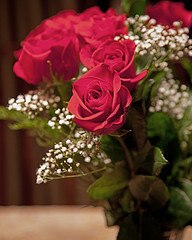

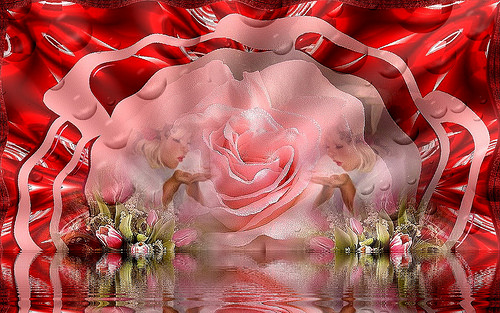

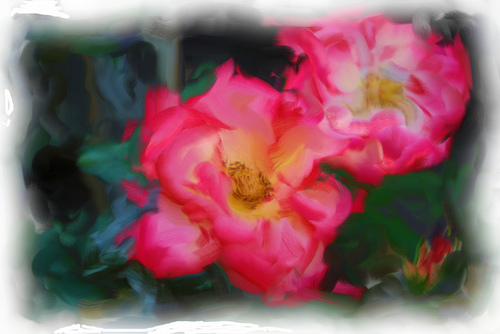

In [26]:
roses = list(data_dir.glob('roses/*'))
for image_path in roses[:3]:
    display.display(Image.open(str(image_path)))

## Load using keras.preprocessing

In [0]:
# The 1./255 is to convert from uint8 to float32 in range [0,1].
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [0]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
#STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

In [29]:
train_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

Found 3670 images belonging to 5 classes.


In [0]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

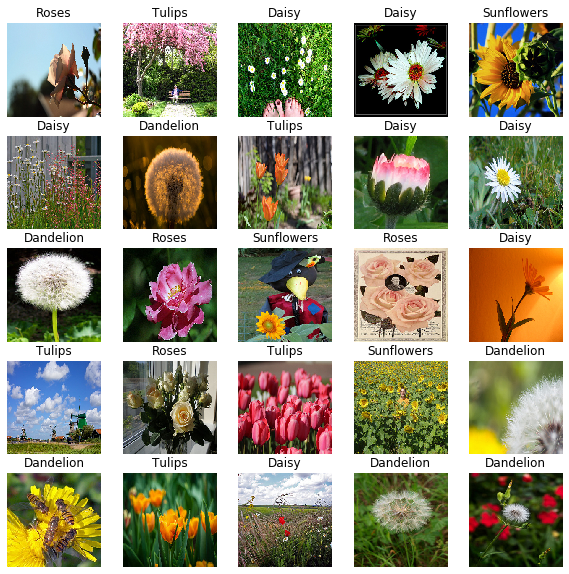

In [31]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

## Load using `tf.data`

The above keras.preprocessing method is convienient, but has three downsides:

1. It's slow. 
2. It lacks fine-grained control.
3. It is not well integrated with the rest of TensorFlow.

To load the files as a tf.data.Dataset first create a dataset of the file paths:

A dataset of all files matching one or more glob patterns. The file_pattern argument should be a small number of glob patterns.

Example:
If we had the following files on our filesystem: - /path/to/dir/a.txt - /path/to/dir/b.py - /path/to/dir/c.py If we pass "/path/to/dir/*.py" as the directory, the dataset would produce: - /path/to/dir/b.py - /path/to/dir/c.py

In [0]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))     # Create a dataset of the file paths

In [9]:
for f in list_ds.take(5):
  print(f.numpy())

b'/root/.keras/datasets/flower_photos/daisy/4563059851_45a9d21a75.jpg'
b'/root/.keras/datasets/flower_photos/tulips/16265883604_92be82b973.jpg'
b'/root/.keras/datasets/flower_photos/sunflowers/5437996076_cf7e2ac32e_n.jpg'
b'/root/.keras/datasets/flower_photos/dandelion/9853885425_4a82356f1d_m.jpg'
b'/root/.keras/datasets/flower_photos/dandelion/144686365_d7e96941ee_n.jpg'


Write a short function that converts a file paths to an (image_data, label) pair:

In [0]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES

In [35]:
get_label('/root/.keras/datasets/flower_photos/dandelion/8978962053_0727b41d26.jpg')

<tf.Tensor: shape=(5,), dtype=bool, numpy=array([False, False,  True, False, False])>

In [36]:
img_str=tf.io.read_file('/root/.keras/datasets/flower_photos/dandelion/8978962053_0727b41d26.jpg')
img_str

<tf.Tensor: shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00H\x00H\x00\x00\xff\xe2\x0cXICC_PROFILE\x00\x01\x01\x00\x00\x0cHLino\x02\x10\x00\x00mntrRGB XYZ \x07\xce\x00\x02\x00\t\x00\x06\x001\x00\x00acspMSFT\x00\x00\x00\x00IEC sRGB\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf6\xd6\x00\x01\x00\x00\x00\x00\xd3-HP  \x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x11cprt\x00\x00\x01P\x00\x00\x003desc\x00\x00\x01\x84\x00\x00\x00lwtpt\x00\x00\x01\xf0\x00\x00\x00\x14bkpt\x00\x00\x02\x04\x00\x00\x00\x14rXYZ\x00\x00\x02\x18\x00\x00\x00\x14gXYZ\x00\x00\x02,\x00\x00\x00\x14bXYZ\x00\x00\x02@\x00\x00\x00\x14dmnd\x00\x00\x02T\x00\x00\x00pdmdd\x00\x00\x02\xc4\x00\x00\x00\x88vued\x00\x00\x03L\x00\x00\x00\x86view\x00\x00\x03\xd4\x00\x00\x00$lumi\x00\x00\x03\xf8\x00\x00\x00\x14meas\x00\x00\x04\x0c\x00\x00\x00$tech\x00\x0

In [37]:
img_uint = tf.image.decode_jpeg(img_str, channels=3)
img_uint

<tf.Tensor: shape=(313, 500, 3), dtype=uint8, numpy=
array([[[14, 29,  0],
        [14, 29,  0],
        [16, 31,  0],
        ...,
        [54, 90,  0],
        [53, 89,  0],
        [52, 88,  0]],

       [[13, 28,  0],
        [13, 28,  0],
        [14, 31,  0],
        ...,
        [54, 90,  0],
        [53, 89,  0],
        [52, 88,  0]],

       [[13, 28,  0],
        [13, 28,  0],
        [13, 29,  0],
        ...,
        [55, 92,  0],
        [54, 90,  0],
        [53, 89,  0]],

       ...,

       [[ 0, 19,  0],
        [ 0, 19,  0],
        [ 2, 19,  0],
        ...,
        [37, 70,  0],
        [37, 70,  0],
        [37, 70,  0]],

       [[ 2, 21,  1],
        [ 2, 21,  1],
        [ 3, 21,  0],
        ...,
        [37, 70,  0],
        [37, 70,  0],
        [37, 70,  0]],

       [[ 7, 22,  0],
        [ 8, 21,  1],
        [ 6, 21,  2],
        ...,
        [39, 72,  1],
        [40, 71,  1],
        [38, 69,  0]]], dtype=uint8)>

In [38]:
img_float = tf.image.convert_image_dtype(img_uint, tf.float32)
img_float

<tf.Tensor: shape=(313, 500, 3), dtype=float32, numpy=
array([[[0.05490196, 0.1137255 , 0.        ],
        [0.05490196, 0.1137255 , 0.        ],
        [0.0627451 , 0.12156864, 0.        ],
        ...,
        [0.21176472, 0.3529412 , 0.        ],
        [0.20784315, 0.34901962, 0.        ],
        [0.20392159, 0.34509805, 0.        ]],

       [[0.0509804 , 0.10980393, 0.        ],
        [0.0509804 , 0.10980393, 0.        ],
        [0.05490196, 0.12156864, 0.        ],
        ...,
        [0.21176472, 0.3529412 , 0.        ],
        [0.20784315, 0.34901962, 0.        ],
        [0.20392159, 0.34509805, 0.        ]],

       [[0.0509804 , 0.10980393, 0.        ],
        [0.0509804 , 0.10980393, 0.        ],
        [0.0509804 , 0.1137255 , 0.        ],
        ...,
        [0.21568629, 0.36078432, 0.        ],
        [0.21176472, 0.3529412 , 0.        ],
        [0.20784315, 0.34901962, 0.        ]],

       ...,

       [[0.        , 0.07450981, 0.        ],
        [0.  

In [39]:
img_final = tf.image.resize(img_float, [IMG_WIDTH, IMG_HEIGHT])
img_final

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[5.41229025e-02, 1.12946436e-01, 0.00000000e+00],
        [6.45133108e-02, 1.24894969e-01, 2.66551971e-03],
        [7.14084134e-02, 1.25552803e-01, 0.00000000e+00],
        ...,
        [2.15222344e-01, 3.60320359e-01, 0.00000000e+00],
        [2.13769406e-01, 3.56928289e-01, 2.66549201e-03],
        [2.06337497e-01, 3.47513974e-01, 0.00000000e+00]],

       [[5.09803966e-02, 1.09803930e-01, 0.00000000e+00],
        [5.58911115e-02, 1.22203030e-01, 0.00000000e+00],
        [6.87539876e-02, 1.25805333e-01, 0.00000000e+00],
        ...,
        [2.16566399e-01, 3.61664444e-01, 0.00000000e+00],
        [2.10775614e-01, 3.62285733e-01, 0.00000000e+00],
        [2.08674684e-01, 3.49851161e-01, 0.00000000e+00]],

       [[4.70850877e-02, 1.04413107e-01, 0.00000000e+00],
        [5.37154749e-02, 1.16482854e-01, 3.30405729e-03],
        [6.69839084e-02, 1.25805333e-01, 3.58229177e-03],
        ...,
        [2.15712547e-01, 3.60810

In [0]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [0]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

Use Dataset.map to create a dataset of image, label pairs:

In [0]:
AUTOTUNE = tf.data.experimental.AUTOTUNE     # deciding the level of parallelism at runtime

To mitigate the impact of the various data extraction overheads, the tf.data.Dataset.interleave transformation can be used to parallelize the data loading step, interleaving the contents of other datasets.

The interleave transformation supports tf.data.experimental.AUTOTUNE which will delegate the decision about what level of parallelism to use to the tf.data runtime.

In [0]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [15]:
for image, label in labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  [ True False False False False]


<b> Basic methods for training </b>
To train a model with this dataset you will want the data:
1. To be well shuffled.
2. To be batched.
3. Batches to be available as soon as possible.

These features can be easily added using the tf.data api.

In [0]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
  # perform shuffling  
  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat(2)

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [17]:
train_ds = prepare_for_training(labeled_ds)

image_batch, label_batch = next(iter(train_ds))

print(image_batch[:5])
print(label_batch[:5])


tf.Tensor(
[[[[0.09411766 0.10028012 0.0579832 ]
   [0.0967287  0.08916567 0.05247099]
   [0.10237096 0.08682473 0.05153062]
   ...
   [0.0197479  0.0197479  0.0197479 ]
   [0.0197479  0.0197479  0.0197479 ]
   [0.01666658 0.01666658 0.01666658]]

  [[0.09411766 0.09961986 0.05765307]
   [0.09915967 0.09159664 0.05490196]
   [0.10588236 0.09411766 0.05882353]
   ...
   [0.02352941 0.02352941 0.02352941]
   [0.02367948 0.02367948 0.02367948]
   [0.0211984  0.0211984  0.0211984 ]]

  [[0.09411766 0.09411766 0.05490196]
   [0.09915967 0.09159664 0.05490196]
   [0.10588236 0.09411766 0.05882353]
   ...
   [0.02422969 0.02422969 0.02422969]
   [0.02538017 0.02538017 0.02538017]
   [0.02800122 0.02800122 0.02800122]]

  ...

  [[0.15825333 0.16679676 0.07393955]
   [0.17714088 0.18820532 0.08207279]
   [0.17717089 0.189916   0.06483592]
   ...
   [0.05261101 0.06437571 0.02908159]
   [0.05283116 0.06459586 0.02930174]
   [0.05545221 0.06721691 0.03192279]]

  [[0.1395459  0.15089042 0.073439

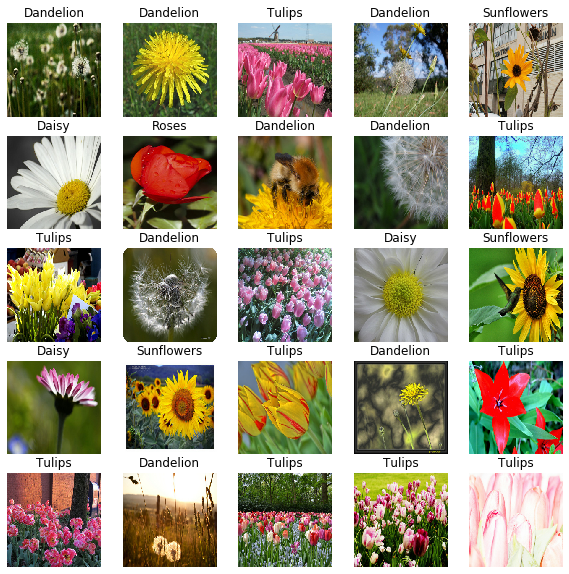

In [47]:
show_batch(image_batch.numpy(), label_batch.numpy())

In [48]:
from keras import models
from keras import layers

Using TensorFlow backend.


In [0]:
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

In [0]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(32, (5, 5), activation='relu', padding='same', input_shape=(224, 224, 3)))  
model.add(tf.keras.layers.MaxPooling2D((2, 2)))                                                            
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))                          
model.add(tf.keras.layers.MaxPooling2D((2, 2)))                                                            
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'))                          
model.add(tf.keras.layers.MaxPooling2D((2, 2)))                                                            
model.add(tf.keras.layers.Flatten())                                                                       
model.add(tf.keras.layers.Dense(128, activation='relu'))                                                   
model.add(tf.keras.layers.Dense(5, activation='softmax'))      

In [51]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0

In [0]:
from tensorflow import keras

In [0]:
model.compile(optimizer=keras.optimizers.SGD(lr=0.001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
train_loss_results = []
train_accuracy_results = []

for e in range(1,6,1):
  print('Start of Epoch : ', e)
  cnt=0
  for batch in train_ds:
    cnt = cnt + 1
    image_batch, label_batch = next(iter(train_ds))
    history = model.fit(image_batch, label_batch)
    print('Batch of 32 samples', cnt)
  train_loss_results.append(history.history['loss'])
  train_accuracy_results.append(history.history['accuracy'])  

Start of Epoch :  1
Train on 32 samples
32/32 [==============================] - 7s 205ms/sample - loss: 1.6040 - accuracy: 0.2500
Batch of 32 samples 1
Train on 32 samples
32/32 [==============================] - 0s 1ms/sample - loss: 1.6158 - accuracy: 0.1562
Batch of 32 samples 2
Train on 32 samples
32/32 [==============================] - 0s 1ms/sample - loss: 1.6245 - accuracy: 0.0938
Batch of 32 samples 3
Train on 32 samples
32/32 [==============================] - 0s 1ms/sample - loss: 1.6107 - accuracy: 0.2500
Batch of 32 samples 4
Train on 32 samples
32/32 [==============================] - 0s 1ms/sample - loss: 1.6094 - accuracy: 0.1875
Batch of 32 samples 5
Train on 32 samples
32/32 [==============================] - 0s 1ms/sample - loss: 1.5313 - accuracy: 0.3750
Batch of 32 samples 6
Train on 32 samples
32/32 [==============================] - 0s 1ms/sample - loss: 1.5775 - accuracy: 0.2812
Batch of 32 samples 7
Train on 32 samples
32/32 [==============================] - 

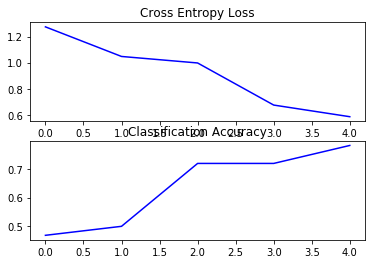

In [22]:
#plot loss
plt.subplot(211)
plt.title('Cross Entropy Loss')
plt.plot(train_loss_results, color='blue', label='train')
# plot accuracy
plt.subplot(212)
plt.title('Classification Accuracy')
plt.plot(train_accuracy_results, color='blue', label='train')